Output from last week
- Use pipelines and get (very) comfortable using them
    - This will make your process robust
    - This will prevent data leakage
    - Never fit on a test data set
- Investigate boosting
- Why performs boosting better on this data set than simple logistic regression, what happens under the hood?
- PCA could help

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns

# Classification with an Academic Success Dataset

## Business Case
- **Goal**: The goal of this competition is to predict academic risk of students in higher education.
- **Evaluation**: Submissions are evaluated using the accuracy score.


## Data Analysis

- Outcome: `Target`, one of the following classes for a student: [`Graduate`, `Dropout`, `Enrolled`]
- 36 Different features: 
    - 7 continuous features with type `float`
    - 29 categorical features with type `int`
- Apparently, no missing values


- Performances
    - `Previous qualification`(0, 1)
- Unknown
    - `Application mode`
    - `Application order`
    - `Mother's qualification`

In [2]:
pd.set_option("display.max_columns", 50)
df = pd.read_csv("train.csv", index_col="id")
df.head(3)

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Admission grade,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,9238,1,1,126.0,1,1,19,5,5,122.6,0,0,0,1,0,1,18,0,0,6,6,6,14.5,0,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate
1,1,17,1,9238,1,1,125.0,1,19,19,9,9,119.8,1,0,0,1,0,0,18,0,0,6,8,4,11.6,0,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout
2,1,17,2,9254,1,1,137.0,1,3,19,2,3,144.7,0,0,0,1,1,0,18,0,0,6,0,0,0.0,0,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout


In [3]:
df.Target.unique()

array(['Graduate', 'Dropout', 'Enrolled'], dtype=object)

In [4]:
df.describe()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Admission grade,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
count,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.00000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000
mean,1.111934,16.054419,1.644410,9001.286377,0.915314,3.658760,132.378766,1.226600,19.837633,23.425076,8.583196,8.882172,125.363971,0.569265,0.003738,0.071382,0.893646,0.315821,0.247393,22.278653,0.006626,0.188871,5.891516,7.352362,4.178520,9.995862,0.05796,0.137053,5.933414,7.234468,4.007201,9.626085,0.062443,11.520340,1.228218,-0.080921
std,0.441669,16.682337,1.229645,1803.438531,0.278416,8.623774,10.995328,3.392183,15.399456,14.921164,17.471591,16.803940,12.562328,0.495182,0.061023,0.257463,0.308292,0.464845,0.431500,6.889241,0.081130,1.175296,1.671776,3.508292,2.687995,5.264224,0.40849,0.933830,1.627182,3.503040,2.772956,5.546035,0.462107,2.653375,1.398816,2.251382
min,1.000000,1.000000,0.000000,33.000000,0.000000,1.000000,95.000000,1.000000,1.000000,1.000000,0.000000,0.000000,95.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,1.000000,1.000000,1.000000,9119.000000,1.000000,1.000000,125.000000,1.000000,1.000000,4.000000,4.000000,5.000000,118.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,18.000000,0.000000,0.000000,5.000000,6.000000,2.000000,10.666667,0.00000,0.000000,5.000000,6.000000,1.000000,10.000000,0.000000,9.400000,0.300000,-1.700000
50%,1.000000,17.000000,1.000000,9254.000000,1.000000,1.000000,133.100000,1.000000,19.000000,19.000000,7.000000,7.000000,124.600000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,19.000000,0.000000,0.000000,6.000000,7.000000,5.000000,12.166667,0.00000,0.000000,6.000000,7.000000,5.000000,12.142857,0.000000,11.100000,1.400000,0.320000
75%,1.000000,39.000000,2.000000,9670.000000,1.000000,1.000000,140.000000,1.000000,37.000000,37.000000,9.000000,9.000000,132.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,23.000000,0.000000,0.000000,6.000000,9.000000,6.000000,13.314286,0.00000,0.000000,6.000000,9.000000,6.000000,13.244048,0.000000,12.700000,2.600000,1.790000
max,6.000000,53.000000,9.000000,9991.000000,1.000000,43.000000,190.000000,109.000000,44.000000,44.000000,194.000000,195.000000,190.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,70.000000,1.000000,20.000000,26.000000,45.000000,26.000000,18.875000,12.00000,19.000000,23.000000,33.000000,20.000000,18.000000,12.000000,16.200000,3.700000,3.510000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76518 entries, 0 to 76517
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  76518 non-null  int64  
 1   Application mode                                76518 non-null  int64  
 2   Application order                               76518 non-null  int64  
 3   Course                                          76518 non-null  int64  
 4   Daytime/evening attendance                      76518 non-null  int64  
 5   Previous qualification                          76518 non-null  int64  
 6   Previous qualification (grade)                  76518 non-null  float64
 7   Nacionality                                     76518 non-null  int64  
 8   Mother's qualification                          76518 non-null  int64  
 9   Father's qualification                      

In [6]:
df.isnull().sum()

Marital status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance                        0
Previous qualification                            0
Previous qualification (grade)                    0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Admission grade                                   0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder                                0
Age at enrol

### Split in train and test set

In [7]:
X = df.drop("Target", axis=1)
y = df.Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

### Createing a baseline model

1. One-hot-encoding for categorical features, create infrequent_dummy feature for unknown classes in test dataset
2. Standard scaling for continuous features
3. Use KNN to predict classes; knn automatically accomodates for multiclass problems

In [8]:
df.dtypes

Marital status                                      int64
Application mode                                    int64
Application order                                   int64
Course                                              int64
Daytime/evening attendance                          int64
Previous qualification                              int64
Previous qualification (grade)                    float64
Nacionality                                         int64
Mother's qualification                              int64
Father's qualification                              int64
Mother's occupation                                 int64
Father's occupation                                 int64
Admission grade                                   float64
Displaced                                           int64
Educational special needs                           int64
Debtor                                              int64
Tuition fees up to date                             int64
Gender        

In [9]:
categorical_features = df.dtypes[df.dtypes == "int64"].index.tolist()
continuous_features = df.dtypes[df.dtypes == "float64"].index.tolist()
print(f"Overview of number of classes per feature: {df[categorical_features].nunique()}")


Overview of number of classes per feature: Marital status                                     6
Application mode                                  22
Application order                                  8
Course                                            19
Daytime/evening attendance                         2
Previous qualification                            21
Nacionality                                       18
Mother's qualification                            35
Father's qualification                            39
Mother's occupation                               40
Father's occupation                               56
Displaced                                          2
Educational special needs                          2
Debtor                                             2
Tuition fees up to date                            2
Gender                                             2
Scholarship holder                                 2
Age at enrollment                                 46
Int

In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_features),
        ('cat', OneHotEncoder(handle_unknown="infrequent_if_exist"), categorical_features)
    ])

In [25]:


pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

Baseline model accuracy is 0.788. For this approach, we simply included all raw data in a randomly chosen model. Quick points of improvement could be:
- Feature importance: Do all features contribute in predicting. Are we now including garbage?
- Model fit: is there another model type that would better suit our situation?
- Data cleaning/feature engineering: can we increase the value of our features?



In [11]:
from sklearn.tree import DecisionTreeClassifier

pipeline_tree = Pipeline([
    ('classifier', DecisionTreeClassifier())
])

pipeline_tree.fit(X_train, y_train)
pipeline_tree.score(X_test, y_test)

0.742093570308416

<Axes: xlabel='importance'>

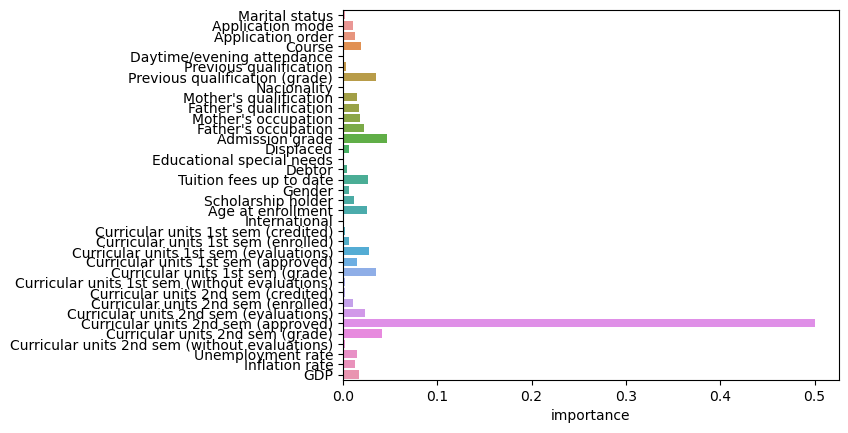

In [16]:
# get an overview of feature importances from pipeline_tree
importances = pipeline_tree.named_steps["classifier"].feature_importances_

# get feature names from classifier
feature_names = pipeline_tree.named_steps["classifier"].feature_names_in_

# create a dataframe with feature importances
feature_importances = pd.DataFrame(importances, index=feature_names, columns=["importance"])

# create a bar plot of feature importances
sns.barplot(data=feature_importances, x="importance", y=feature_importances.index)

Ideas:
- Mutual information
    - StatQuest: https://www.youtube.com/watch?v=eJIp_mgVLwE&t=379s
    - Kaggle: https://www.kaggle.com/code/ryanholbrook/mutual-information
- PCA
    - Besides dimension reduction, also feature importance


### Draft

In [4]:
columns = ['GDP', 'Inflation rate', 'Unemployment rate', 'Nacionality', 'Target']
df_country = df[columns]

In [5]:
df_country

,GDP,Inflation rate,Unemployment rate,Nacionality,Target
0,2.02,0.6,11.1,1,Graduate
1,2.02,0.6,11.1,1,Dropout
2,-0.92,0.3,16.2,1,Dropout
3,2.02,0.6,11.1,1,Enrolled
4,0.32,2.6,7.6,1,Graduate
...,...,...,...,...,...
76513,0.79,-0.3,13.9,1,Graduate
76514,-3.12,-0.8,9.4,1,Graduate
76515,-3.12,-0.8,9.4,1,Enrolled
76516,0.32,2.6,7.6,1,Dropout


/home/luukvanroessel/miniconda3/envs/ml-luuk/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/luukvanroessel/miniconda3/envs/ml-luuk/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/luukvanroessel/miniconda3/envs/ml-luuk/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/luukvanro

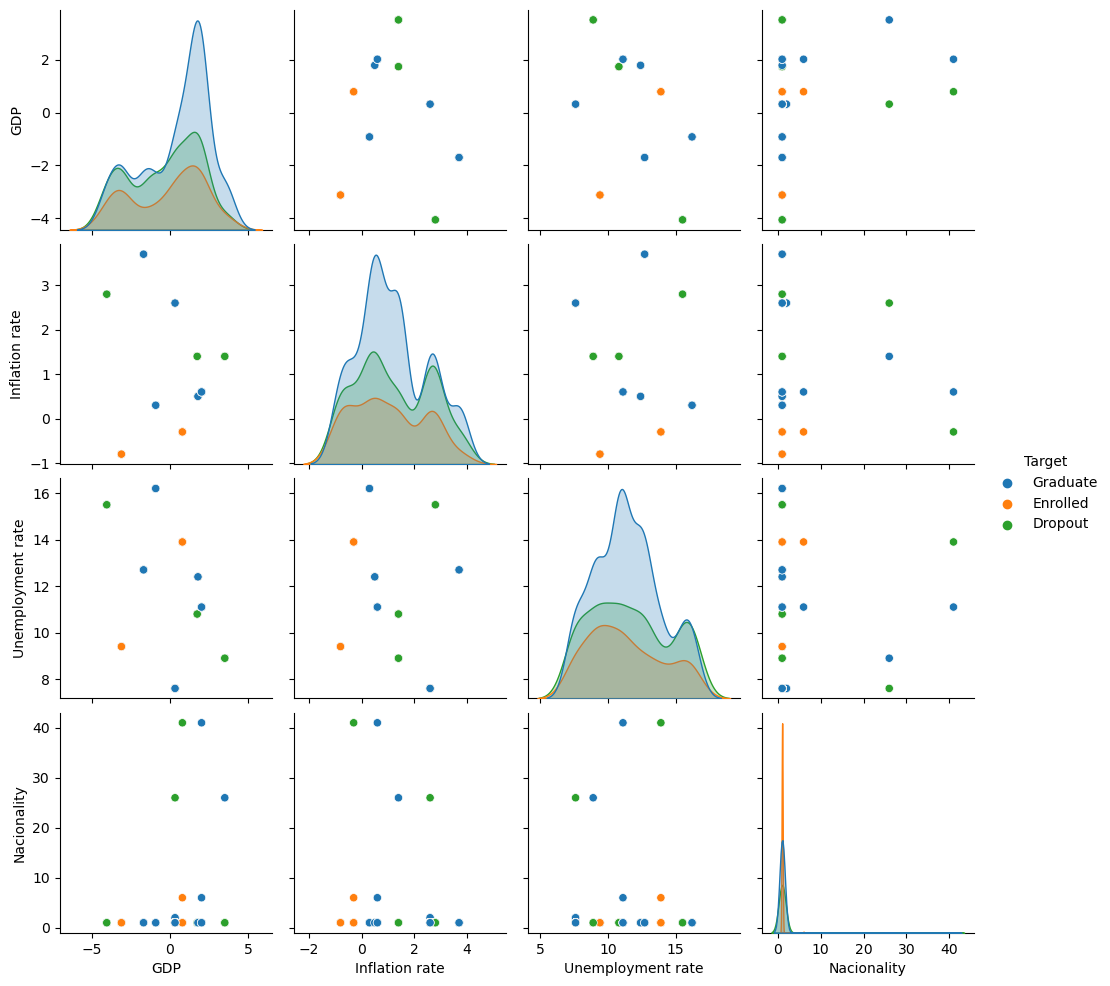

In [4]:


sns.pairplot(df_country.sample(1000), hue='Target')

### Feature Engineering